In [89]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from wordcloud import WordCloud
import spacy
import nltk
from gensim import corpora, models, similarities, matutils
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.cluster import KMeans

from sklearn.feature_extraction import stop_words as sklearn_stopwords
from nltk.corpus import stopwords as nltk_stopwords

In [90]:
df = pd.read_csv('/home/cneiderer/Downloads/inaug_speeches_mod.csv')

In [91]:
df.head()

,Unnamed: 0,Name,Inaugural Address,Date,text
0,4,George Washington,First Inaugural Address,"Thursday, April 30, 1789",Fellow-Citizens of the Senate and o...
1,5,George Washington,Second Inaugural Address,"Monday, March 4, 1793",Fellow Citizens: I AM again calle...
2,6,John Adams,Inaugural Address,"Saturday, March 4, 1797","WHEN it was first perceived, in ea..."
3,7,Thomas Jefferson,First Inaugural Address,"Wednesday, March 4, 1801",Friends and Fellow-Citizens: CALL...
4,8,Thomas Jefferson,Second Inaugural Address,"Monday, March 4, 1805","PROCEEDING, fellow-citizens, to th..."


In [92]:
docs = list(df.text)
len(docs)

58

In [93]:
import re

# custom stop words and stop phrases
custom_stopwords = ['mr', 'miss', 'vice president', 'chief justice', 'united states', 'god bless', 
                    'fellow citizens', 'fellow-citizens', 'government']
docs_orig = docs.copy()
for wd in custom_stopwords:
    remove = re.compile(wd, re.I)   
    for idx in range(len(docs)):
        docs[idx] = remove.sub(' ', docs[idx])
#         docs[idx] = re.sub(wd, '', docs[idx], flags=re.I)

        docs[idx] = re.sub('<[Uu]\+\d{4,4}>', ' ', docs[idx])

In [94]:
from nltk.tokenize import sent_tokenize
from nltk.tokenize import word_tokenize
lmtzr = nltk.stem.wordnet.WordNetLemmatizer()
stemmer = nltk.stem.porter.PorterStemmer()

# for idx, doc in enumerate(docs):
    
#     processed_words = []    
#     sentences = sent_tokenize(doc)
#     for sentence in sentences:
#         words = word_tokenize(sentence)
#         for word in words:
#             processed_words.append(lmtzr.lemmatize(word))
# #             processed_words.append(stemmer.stem(word))
# #             processed_words.append(lmtzr.lemmatize(stemmer.stem(word)))
                               
#     docs[idx] = ' '.join(processed_words)          

In [95]:
sw = set(nltk_stopwords.words('english')).union(sklearn_stopwords.ENGLISH_STOP_WORDS)

# Create a CountVectorizer for parsing/counting words
count_vectorizer = CountVectorizer(ngram_range=(2, 4), 
#                                    min_df=0.02, 
                                   max_df=0.8,
#                                    max_features=2500,
                                   stop_words=sw)
count_vectorizer.fit(docs)

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=0.8, max_features=None, min_df=1,
        ngram_range=(2, 4), preprocessor=None,
        stop_words={'above', 'anyhow', 'forty', 'rather', 'which', 'and', 'anywhere', 'any', 'if', 'where', 'inc', 'either', 'together', 'both', 'since', 'wherever', 'now', 've', "wouldn't", 'becoming', 'whereupon', 'sometimes', 'fire', 'latter', 'beforehand', 'there', 't', 'itself', 'whole', 'again', 'did'..., 'neither', 'herself', 'seeming', 'all', 'once', 'across', 'though', 'except', 'whose', 'whenever'},
        strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
        tokenizer=None, vocabulary=None)

In [96]:
# Create the term-document matrix
# Transpose it so the terms are the rows
counts = count_vectorizer.transform(docs).transpose()

In [97]:
counts.shape

(161734, 58)

In [98]:
# Convert sparse matrix of counts to a gensim corpus
corpus = matutils.Sparse2Corpus(counts)

In [99]:
id2word = dict((v, k) for k, v in count_vectorizer.vocabulary_.items())

In [100]:
len(id2word)

161734

In [101]:
# Create lda model (equivalent to "fit" in sklearn)
lda = models.LdaModel(corpus=corpus, 
                      num_topics=20, 
                      alpha=0.1, #'asymmetric',
                      minimum_probability=0.03, 
                      id2word=id2word, passes=10, random_state=129)

In [102]:
lda.print_topics()

[(0,
  '0.000*"political parties" + 0.000*"nuclear weapons" + 0.000*"time history" + 0.000*"new breeze" + 0.000*"men women" + 0.000*"human freedom" + 0.000*"soviet union" + 0.000*"southern states" + 0.000*"new engagement" + 0.000*"breeze blowing"'),
 (1,
  '0.000*"american people" + 0.000*"house representatives" + 0.000*"good assure" + 0.000*"public good" + 0.000*"executive department" + 0.000*"human race" + 0.000*"happiness people" + 0.000*"public private" + 0.000*"order right" + 0.000*"th day"'),
 (2,
  '0.000*"new world" + 0.000*"renew america" + 0.000*"fellow americans" + 0.000*"representative democracy" + 0.000*"change friend" + 0.000*"economy world" + 0.000*"today celebrate" + 0.000*"let resolve" + 0.000*"democracy freedom" + 0.000*"great small"'),
 (3,
  '0.000*"foreign nations" + 0.000*"public service" + 0.000*"public private" + 0.000*"regard rights" + 0.000*"american people" + 0.000*"shall endeavor" + 0.000*"national security" + 0.000*"people america" + 0.000*"shall leave" + 0

In [103]:
# Transform the docs from the word space to the topic space (like "transform" in sklearn)
lda_corpus = lda[corpus]
lda_corpus

In [104]:
# Store the documents' topic vectors in a list so we can take a peak
lda_docs = [doc for doc in lda_corpus]

In [105]:
# Check out the document vectors in the topic space for the first 5 documents
for pres in zip(df['Name'], lda_docs):
# for pres in zip(df['Name'], df['Date'], lda_docs):
    print(pres)

('George Washington', [(1, 0.99885815)])
('George Washington', [(3, 0.98749995)])
('John Adams', [(3, 0.93050498), (8, 0.068855822)])
('Thomas Jefferson', [(2, 0.48705983), (17, 0.50521892)])
('Thomas Jefferson', [(4, 0.99504554)])
('James Madison', [(9, 0.99864286)])
('James Madison', [(14, 0.29006487), (16, 0.70869201)])
('James Monroe', [(19, 0.99951828)])
('James Monroe', [(11, 0.97723502)])
('John Quincy Adams', [(9, 0.10069542), (17, 0.89881063)])
('Andrew Jackson', [(3, 0.99866009)])
('Andrew Jackson', [(6, 0.99861914)])
('Martin Van Buren', [(8, 0.99962163)])
('William Henry Harrison', [(7, 0.99980265)])
('James Knox Polk', [(18, 0.99967247)])
('Zachary Taylor', [(4, 0.99866009)])
('Franklin Pierce', [(3, 0.91587847), (16, 0.083691992)])
('James Buchanan', [(19, 0.99946541)])
('Abraham Lincoln', [(14, 0.99954426)])
('Abraham Lincoln', [(10, 0.99771082)])
('Ulysses S. Grant', [(9, 0.99859774)])
('Ulysses S. Grant', [(3, 0.34203583), (12, 0.6568206)])
('Rutherford B. Hayes', [(0,

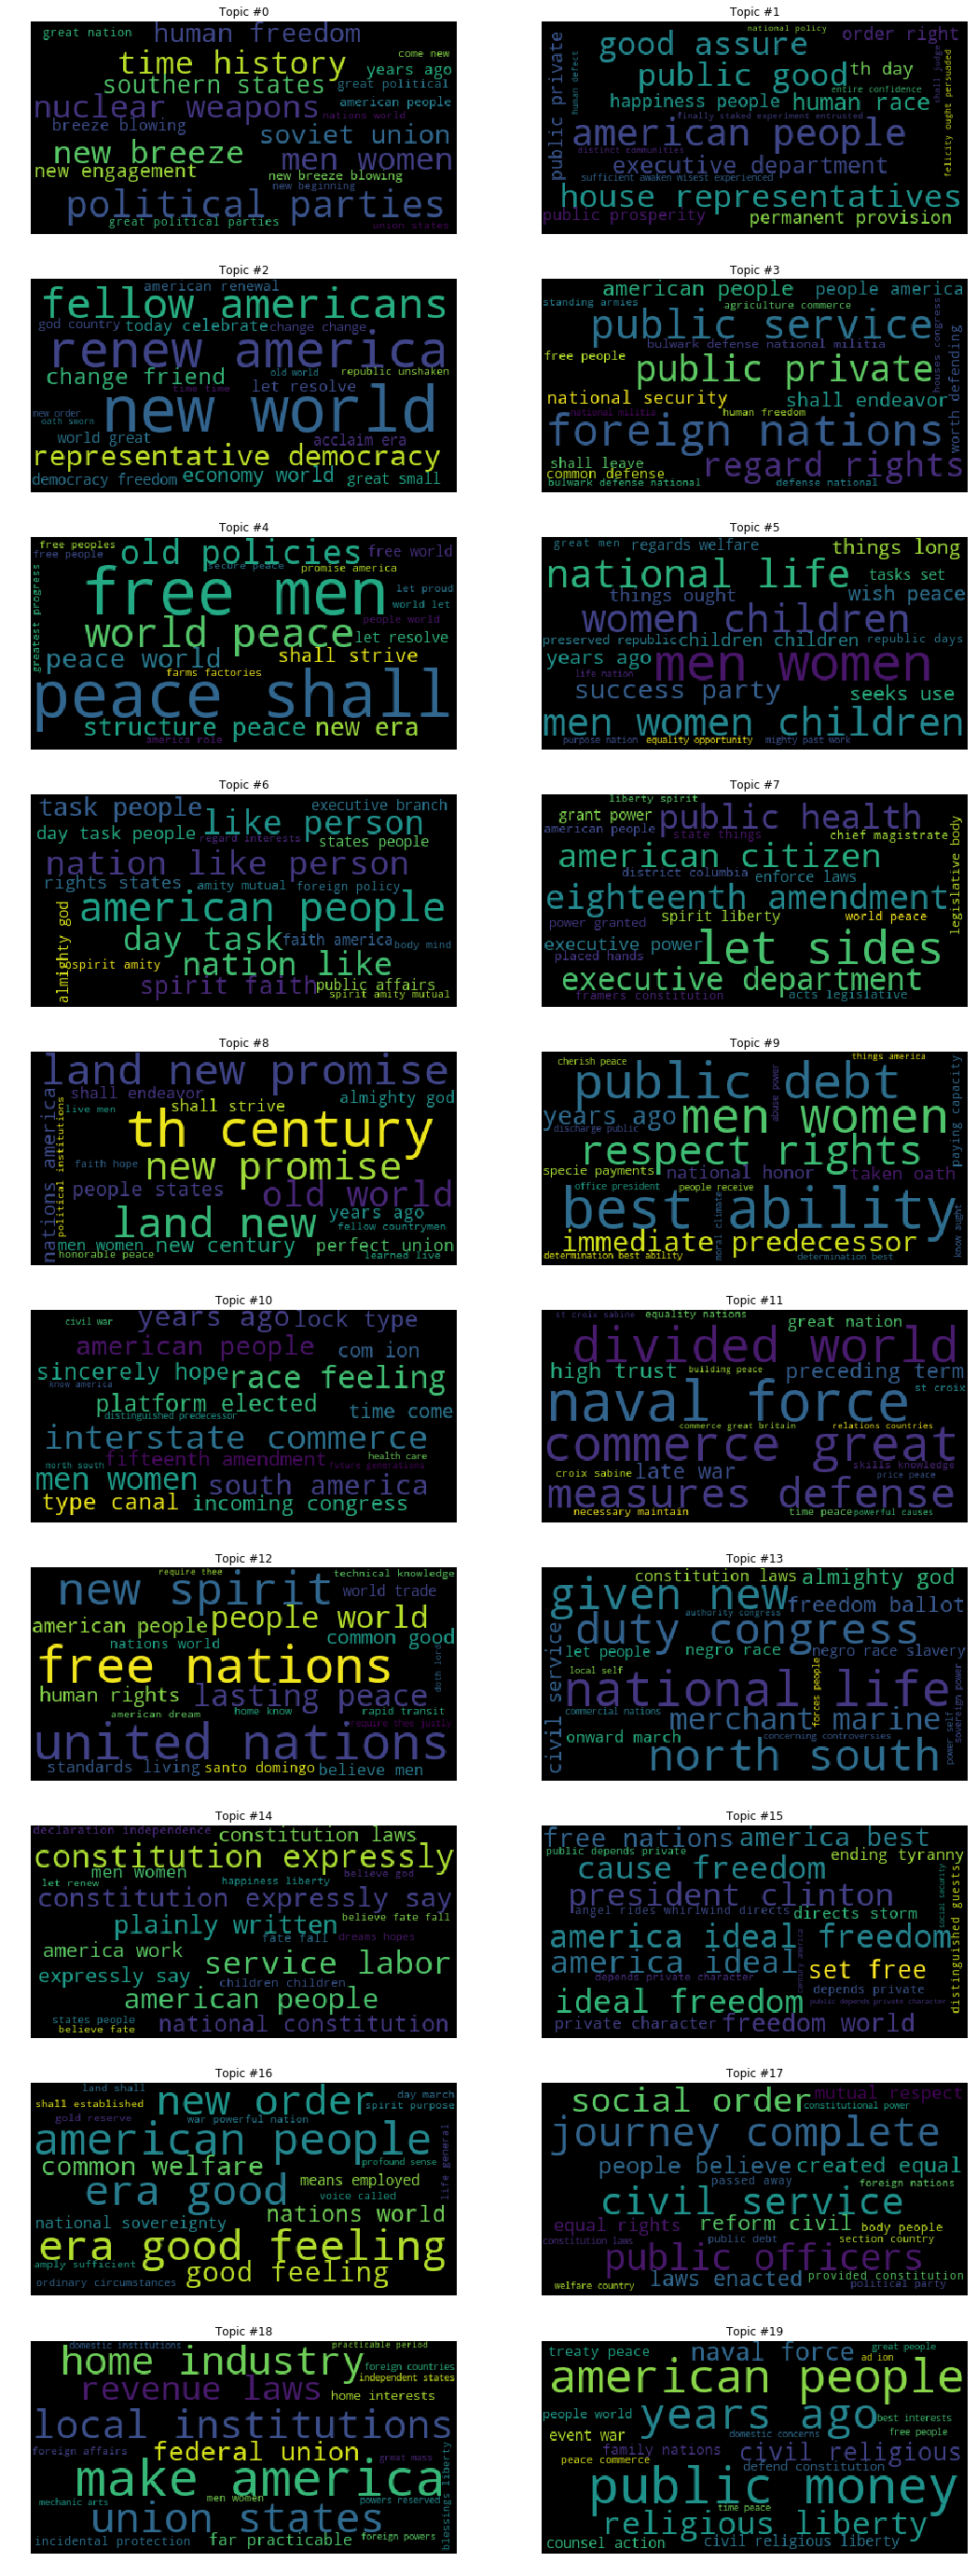

In [106]:
ncol = 2
nrow = int(np.ceil(lda.num_topics / ncol))

figwidth = ncol * 9
figheight = nrow * 5
fig, axes = plt.subplots(nrow, ncol, figsize=(figwidth, figheight))
ax = axes.flatten()

num_words = 20 # Number of words to include in word cloud
for t in range(lda.num_topics): 
    plt.sca(ax[t])    
    plt.title("Topic #" + str(t))
    plt.axis("off")    
    plt.imshow(WordCloud().fit_words(dict(lda.show_topic(t, num_words))))

In [107]:
# num_words = 30 # Number of words to include in word cloud
# for t in range(lda.num_topics):
#     plt.figure(figsize=(16,12))
#     plt.imshow(WordCloud().fit_words(dict(lda.show_topic(t, num_words))))
#     plt.axis("off")
#     plt.title("Topic #" + str(t))
#     plt.show()

In [108]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import NMF, LatentDirichletAllocation

In [109]:
n_samples = 2000
n_features = 1000
n_topics = 20
n_top_words = 20

def print_top_words(model, feature_names, n_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print("Topic #%d:" % topic_idx)
        print(" ".join([feature_names[i]
                        for i in topic.argsort()[:-n_top_words - 1:-1]]))
    print()

In [110]:
tfidf_vectorizer = TfidfVectorizer(max_df=0.8, min_df=0.02,
                                   max_features=n_features,
                                   stop_words='english')

tfidf = tfidf_vectorizer.fit_transform(docs)

In [111]:
nmf = NMF(n_components=n_topics, random_state=129, alpha=.1, l1_ratio=.5).fit(tfidf)

tfidf_feature_names = tfidf_vectorizer.get_feature_names()
print_top_words(nmf, tfidf_feature_names, n_top_words)

Topic #0:
public constitution union states laws congress interests foreign peace national state executive duties policy powers duty best general revenue support
Topic #1:
america today americans freedom let work know american make children god century peace earth day history generation old women man
Topic #2:
democracy millions road economic progress problems democratic purpose understanding republic moral practical did forces science change way women aid bad
Topic #3:
business negro tariff south race feeling proper legislation amendment congress likely army trade passed consideration coast predecessor prevent law navy
Topic #4:
war god union let drawn years seeking conflict said came needs right ago occasion cause come southern contest devoted strive
Topic #5:
war honorable carried issue reliance spirit class sense practice consideration distinguished placed arms obligations period citizens justice society political long
Topic #6:
peoples peace freedom help communism program economic 

In [112]:
tfidf_feature_names

['abiding',
 'ability',
 'able',
 'abroad',
 'abuses',
 'accept',
 'accomplished',
 'according',
 'achieve',
 'act',
 'action',
 'acts',
 'actual',
 'adapted',
 'add',
 'added',
 'additional',
 'adequate',
 'administration',
 'adopt',
 'adopted',
 'adoption',
 'advance',
 'advanced',
 'advancement',
 'advantage',
 'advantages',
 'affairs',
 'afford',
 'age',
 'aggression',
 'ago',
 'agriculture',
 'aid',
 'alike',
 'almighty',
 'amendment',
 'america',
 'american',
 'americans',
 'ample',
 'ancient',
 'answer',
 'anxiety',
 'appeal',
 'appear',
 'application',
 'arise',
 'armed',
 'armies',
 'arms',
 'army',
 'ask',
 'aspirations',
 'assume',
 'assurance',
 'assure',
 'assured',
 'attempt',
 'attention',
 'authorities',
 'authority',
 'avoid',
 'away',
 'bad',
 'balance',
 'based',
 'basis',
 'battle',
 'bear',
 'began',
 'beginning',
 'belief',
 'believe',
 'believed',
 'belongs',
 'benefit',
 'benefits',
 'best',
 'better',
 'bind',
 'birth',
 'blessed',
 'blessings',
 'blood',
 'bod